In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV

from pathlib import Path

# Load data
project_root = Path.cwd().resolve()
csv_path = project_root.parent / "data" / "creditcard.csv"
if not csv_path.exists():
    csv_path = project_root / "data" / "creditcard.csv"
df = pd.read_csv(csv_path)

X = df.drop("Class", axis=1)
y = df["Class"]

# train-val-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
val_preds   = lr.predict(X_val)
test_preds  = lr.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))

Train Accuracy: 0.9767501740957263
Validation Accuracy: 0.9751939889751062
Test Accuracy: 0.9758084336926371


In [9]:
# Calibrate the model using isotonic and sigmoid regression
cal_sig = CalibratedClassifierCV(lr, method="sigmoid", cv="prefit")
cal_sig.fit(X_val, y_val)

cal_iso = CalibratedClassifierCV(lr, method="isotonic", cv="prefit")
cal_iso.fit(X_val, y_val)
raw_probs = lr.predict_proba(X_test)
cal_probs = cal_iso.predict_proba(X_test)

def entropy(p):
    return -np.sum(p*np.log(p+1e-9), axis=1)

raw_conf = np.mean(np.max(raw_probs, axis=1))
cal_conf = np.mean(np.max(cal_probs, axis=1))

raw_ent = np.mean(entropy(raw_probs))
cal_ent = np.mean(entropy(cal_probs))

print("Raw Mean Confidence:", raw_conf)
print("Calibrated Mean Confidence:", cal_conf)

print("Raw Mean Entropy:", raw_ent)
print("Calibrated Mean Entropy:", cal_ent)

Raw Mean Confidence: 0.9466868234689086
Calibrated Mean Confidence: 0.9991943343855643
Raw Mean Entropy: 0.15584667875211625
Calibrated Mean Entropy: 0.003525978336308076


c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [6]:
# Calibrate the model using sigmoid regression
calibrated_lr = CalibratedClassifierCV(
    lr,
    method="sigmoid",
    cv="prefit"
)

calibrated_lr.fit(X_val, y_val)
cal_probs = calibrated_lr.predict_proba(X_test)
raw_probs = lr.predict_proba(X_test)

def entropy(p):
    return -np.sum(p*np.log(p+1e-9), axis=1)

raw_conf = np.mean(np.max(raw_probs, axis=1))
cal_conf = np.mean(np.max(cal_probs, axis=1))

raw_ent = np.mean(entropy(raw_probs))
cal_ent = np.mean(entropy(cal_probs))

print("Raw Mean Confidence:", raw_conf)
print("Calibrated Mean Confidence:", cal_conf)

print("Raw Mean Entropy:", raw_ent)
print("Calibrated Mean Entropy:", cal_ent)

Raw Mean Confidence: 0.9466868234689086
Calibrated Mean Confidence: 0.9991509334001027
Raw Mean Entropy: 0.15584667875211625
Calibrated Mean Entropy: 0.005721304596405524


c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [6]:
# Expected Calibration Error (ECE)
def expected_calibration_error(probs, y, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    bins = np.linspace(0,1,n_bins+1)
    ece = 0.0

    for i in range(n_bins):
        idx = (confidences > bins[i]) & (confidences <= bins[i+1])
        if np.sum(idx) == 0:
            continue

        acc = np.mean(predictions[idx] == y.iloc[idx])
        conf = np.mean(confidences[idx])
        ece += np.abs(acc - conf) * np.sum(idx) / len(y)

    return ece

raw_ece = expected_calibration_error(raw_probs, y_test.reset_index(drop=True))
cal_ece = expected_calibration_error(cal_probs, y_test.reset_index(drop=True))

print("Raw ECE:", raw_ece)
print("Calibrated ECE:", cal_ece)

Raw ECE: 0.029121610223721145
Calibrated ECE: 0.00034575402177055355


In [11]:
#drift
def noise_drift(X, intensity):
    return X + np.random.normal(0, intensity, X.shape)

drift_levels = [0.0, 0.2, 0.5, 1.0]

lr_results = []

for d in drift_levels:
    Xd = noise_drift(X_test, d)

    rp = lr.predict_proba(Xd)
    sp = cal_sig.predict_proba(Xd)
    ip = cal_iso.predict_proba(Xd)

    lr_results.append([
        d,
        accuracy_score(y_test, np.argmax(rp,1)),
        accuracy_score(y_test, np.argmax(sp,1)),
        accuracy_score(y_test, np.argmax(ip,1)),
        np.mean(np.max(rp,1)),
        np.mean(np.max(sp,1)),
        np.mean(np.max(ip,1)),
        np.mean(entropy(rp)),
        np.mean(entropy(sp)),
        np.mean(entropy(ip))
    ])
lr_results


[[0.0,
  0.9758084336926371,
  0.9990519995786665,
  0.999385555282469,
  np.float64(0.9466868234689086),
  np.float64(0.9991509334001027),
  np.float64(0.9991943343855643),
  np.float64(0.15584667875211625),
  np.float64(0.005721304596405523),
  np.float64(0.0035259783363080746)],
 [0.2,
  0.9616410940627085,
  0.9990519995786665,
  0.9993328885923949,
  np.float64(0.9366949235787707),
  np.float64(0.9991276434845859),
  np.float64(0.9990579917815252),
  np.float64(0.17017428002748963),
  np.float64(0.005865248053649438),
  np.float64(0.0042912758067075235)],
 [0.5,
  0.8834837259927671,
  0.9991222218320986,
  0.9993679997191109,
  np.float64(0.9193896029997031),
  np.float64(0.9990091499318392),
  np.float64(0.9977278420537339),
  np.float64(0.19248704431459798),
  np.float64(0.006613651356022561),
  np.float64(0.009990029423626978)],
 [1.0,
  0.759365893051508,
  0.9991397773954567,
  0.9988062216916541,
  np.float64(0.9298672704403191),
  np.float64(0.9983050369864577),
  np.float

In [12]:
columns = [
    "drift",
    "raw_acc","sig_acc","iso_acc",
    "raw_conf","sig_conf","iso_conf",
    "raw_ent","sig_ent","iso_ent"
]

lr_df = pd.DataFrame(lr_results, columns=columns)
lr_df["model"] = "LR"

lr_df.to_csv("lr_results.csv", index=False)


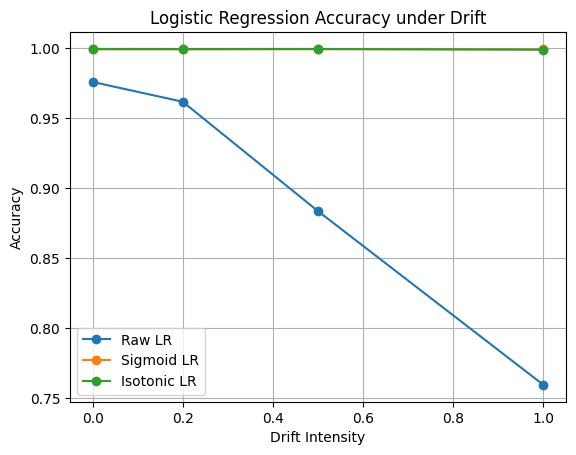

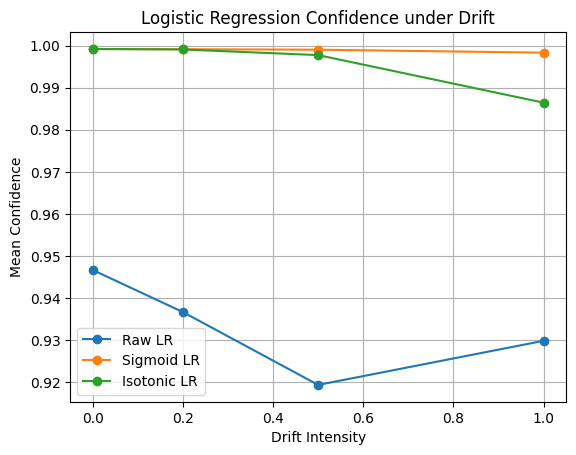

In [14]:
drift = [r[0] for r in lr_results]

raw_acc = [r[1] for r in lr_results]
sig_acc = [r[2] for r in lr_results]
iso_acc = [r[3] for r in lr_results]
plt.figure()
plt.plot(drift, raw_acc, marker='o')
plt.plot(drift, sig_acc, marker='o')
plt.plot(drift, iso_acc, marker='o')

plt.xlabel("Drift Intensity")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy under Drift")
plt.legend(["Raw LR", "Sigmoid LR", "Isotonic LR"])
plt.grid(True)
plt.show()

raw_conf = [r[4] for r in lr_results]
sig_conf = [r[5] for r in lr_results]
iso_conf = [r[6] for r in lr_results]

plt.figure()
plt.plot(drift, raw_conf, marker='o')
plt.plot(drift, sig_conf, marker='o')
plt.plot(drift, iso_conf, marker='o')

plt.xlabel("Drift Intensity")
plt.ylabel("Mean Confidence")
plt.title("Logistic Regression Confidence under Drift")
plt.legend(["Raw LR", "Sigmoid LR", "Isotonic LR"])
plt.grid(True)
plt.show()
